In [53]:
#Libraries
import pandas as pd
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import tabulate
import warnings
warnings.filterwarnings("ignore")

In [54]:
# Applies the two-step Engle & Granger test for cointegration.
def step1(y, x):
    '''
    First fits the long-run relationship
    y_t = c + gamma * x_t + z_t
    z_t is the residual (error correction term)
    '''
    regression = OLS(y, add_constant(x), has_const=True)
    regression_fit = regression.fit()
    c, gamma = regression_fit.params
    z = regression_fit.resid
    return c, gamma, z
def step2(y, x):
    """
    Dickey-Fuller phi=1 vs phi < 1 in
    z_t = phi * z_(t-1) + eta_t

    If this implies phi < 1, the z series is stationary,
    and thus the series y and x are concluded to be cointegrated
    """
    c, gamma, z = step1(y, x)
    adfstat, pvalue, usedlag, nobs, crit_values = adfuller(z, maxlag=1, autolag=None)
    return adfstat, pvalue



```
# This is formatted as code
```

### Below we have selected the top 12 performing stocks in the healthcare industry.

In [55]:
stocks = ['LLY',"UNH","NVO","JNJ","MRK","ABBV","AZN","NVS","TMO","PFE","ABT","DHR"]
stock_data =  yf.download(stocks, start = "2017-06-01" ,end= "2020-06-01")['Adj Close']
stock_data.head()

[*********************100%%**********************]  12 of 12 completed


,ABBV,ABT,AZN,DHR,JNJ,LLY,MRK,NVO,NVS,PFE,TMO,UNH
Date,,,,,,,,,,,,
2017-06-01,50.032452,41.197350,28.862354,73.764122,109.020226,71.212143,51.033142,17.125454,58.493176,24.614954,171.932159,163.143005
2017-06-02,50.437450,41.554806,29.111092,74.398102,110.120766,71.336792,51.197357,17.523809,58.757553,24.487024,173.476212,162.970444
2017-06-05,50.632450,41.662037,28.953558,74.132500,110.357796,70.642387,50.884563,17.408287,58.471733,24.344044,173.525375,162.952271
2017-06-06,50.902443,41.429699,28.970144,73.447121,110.755707,70.410896,50.571770,17.256910,58.478882,24.133333,173.161484,164.269531
2017-06-07,51.562447,41.608440,28.920399,73.190086,110.687965,70.677979,50.094746,17.025862,58.035862,24.080667,173.427002,166.440781


In [56]:
def coint(stock_data, stocks):
    data = {'Pairs': [],
                     'Constant': [],
                     'Gamma': [],
                     'P-Value': []}
    zvalues = {}

    for stock1 in stocks:
        for stock2 in stocks:
            if stock1 != stock2:
                pair = stock1, stock2
                c, gamma, zvalue = step1(np.log(stock_data[stock1]),np.log(stock_data[stock2]))
                t_stat, pvalue = step2(np.log(stock_data[stock1]),np.log(stock_data[stock2]))

                data['Pairs'].append(pair)
                data['Constant'].append(c)
                data['Gamma'].append(gamma)
                data['P-Value'].append(pvalue)
                zvalues[pair] = zvalue
    data = pd.DataFrame(data,index=pd.MultiIndex.from_tuples(data['Pairs']))
    data.drop('Pairs', axis=1, inplace=True)
    return data,pd.DataFrame(zvalues)

In [57]:
# Visualize the P-values
def plot_pvalues(coint_data):
    plt.figure(figsize=(20, 5))
    plt.hist(coint_data['P-Value'], bins=100)
    plt.xlabel('P-value')
    plt.ylabel('Number of observations')
    plt.title('All obtained P-values')
    plt.show()
    coint_mat = coint_data.unstack(level=0)['P-Value']
    coint_mat = coint_mat.fillna(1)
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.heatmap(coint_mat, annot=True, cmap="YlGnBu")
    plt.title("Heatmap of Pairs")
    plt.show()

          Constant     Gamma   P-Value
LLY UNH  -2.375126  1.281401  0.197530
    NVO   0.783272  1.231176  0.471919
    JNJ  -7.662939  2.558380  0.129158
    MRK   0.031043  1.114418  0.596316
    ABBV  4.834387 -0.064485  0.898428
         Constant     Gamma   P-Value
DHR AZN  0.416499  1.180704  0.011824
    NVS -2.596153  1.712116  0.092818
    TMO -1.219246  1.060570  0.003549
    PFE  1.073405  1.033022  0.942164
    ABT  0.435796  1.001115  0.018338


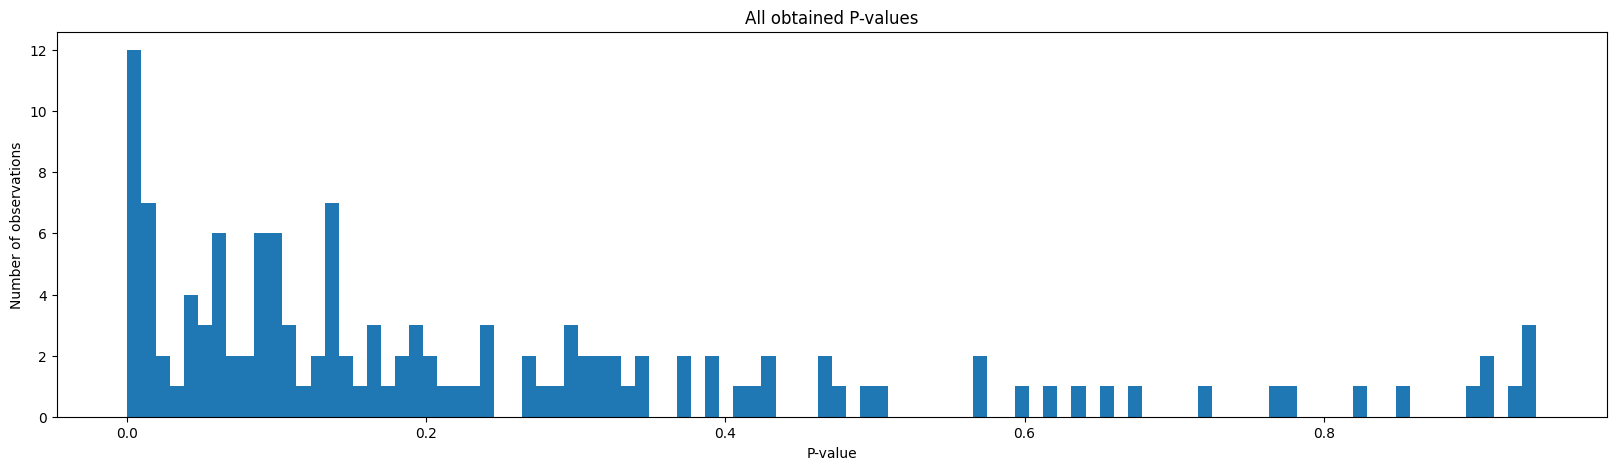

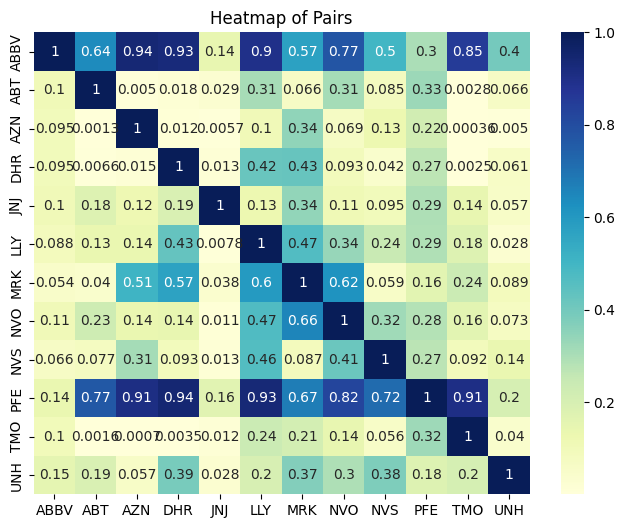

In [58]:
coint_analysis,zvalues = coint(stock_data,stocks)
print(coint_analysis.head())
print(coint_analysis.tail())
plot_pvalues(coint_analysis)

In [59]:
tradable_pairs = coint_analysis[coint_analysis['P-Value'] < 0.005].sort_values('P-Value')
tradable_pairs.head(10)

Constant     Gamma   P-Value
TMO AZN  1.557100  1.109095  0.000361
AZN TMO -0.977087  0.823720  0.000703
ABT AZN  0.177878  1.123624  0.001274
    TMO -1.406494  1.014355  0.001557
TMO DHR  1.314469  0.906980  0.002490
    ABT  1.568924  0.941917  0.002805
DHR TMO -1.219246  1.060570  0.003549
UNH AZN  3.226433  0.618691  0.004981

In [60]:
def select_stock_pair(stock_data,S1,S2):
    plt.figure(figsize=(20,5))
    plt.plot(np.log(stock_data[S1]),color="blue",label=S1)
    plt.plot(np.log(stock_data[S2]),color="black",label=S2)
    plt.xlabel('Time')
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()
    c,gamma,zvalue = step1(np.log(stock_data[S1]),np.log(stock_data[S2]))
    plt.figure(figsize=(20,5))
    plt.title('Error-correction term (Spread)')
    zvalue.plot()
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.axhline(0.05,color='g') # Note 0.005 is randomly chosen
    plt.axhline(0,color='black') # Note -0.005 is randomly chosen
    plt.axhline(-0.05,color='r') # Note -0.005 is randomly chosen
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
    plt.show()
    return zvalue,gamma

In [61]:
def zscore(series,window_length=20):
    zscores = []
    for i in range(window_length, len(series)):
      window = series[i-window_length:i]
      zscores.append((series[i]-window.mean())/window.std())
    return pd.Series(zscores, index = series.index[window_length:])

In [62]:
def strategy(S1,S2,threshold=1,stop_loss=0.5):
    strat = yf.download([S1,S2], start = "2020-07-01" ,end= "2023-07-01")['Adj Close']
    gamma = select_stock_pair(stock_data,S1,S2)[1]
    spread = np.log(strat[S1])-gamma*np.log(strat[S2])
    strat['zscore'] = zscore(spread)
    #Normal Signal
    strat['signal'] = np.select([strat['zscore'] > threshold, strat['zscore'] < -threshold], [1, -1], default = 0)
    # Stop loss
    strat.loc[abs(strat["zscore"]) > threshold+stop_loss, "signal"] = 0
    # Take profit
    strat.loc[abs(strat["zscore"]) == 0, "signal"] = 0
    strat['position1'] = -strat['signal'].diff()
    strat['position2'] = -strat['position1']
    strat=strat.fillna(0)
    return strat, gamma

In [63]:
def visualize_strategy(strat):
    fig, axs = plt.subplots(3, sharex=True, figsize=(15,12))
    axs[0].set_title('Market Value')
    axs[0].plot(strat[S1],label=S1,color='black')
    axs[0].plot(strat[S1][strat['position1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[0].plot(strat[S1][strat['position1'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[0].grid()
    axs[0].legend()
    axs[1].set_title('Market Value')
    axs[1].plot(strat[S2],label=S2,color='black')
    axs[1].plot(strat[S2][strat['position2'] == -1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[1].plot(strat[S2][strat['position2'] == 1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[1].grid()
    axs[1].legend()
    axs[2].set_title('Zscore')
    axs[2].plot(strat['zscore'])
    axs[2].grid()
    axs[2].axhline(1.5,color='r')
    axs[2].axhline(1,color='g')
    axs[2].axhline(0,color='black')
    axs[2].axhline(-1,color='g')
    axs[2].axhline(-1.5,color='r')
    axs[2].fill_between(strat.index,strat.zscore,1,where = strat.zscore >= 1, color = 'lightcoral')
    axs[2].fill_between(strat.index,strat.zscore,-1,where = strat.zscore <= -1, color = 'lightgreen')
    plt.show()

In [64]:
def pnl(strategy):
    initial_capital = 100000
    # dividing capital in ratio gamma:1
    C2 = initial_capital/(1+gamma)
    C1 = gamma*C2
    # Shares to buy for each stock
    shares1 = C1// (strategy[S1][0])
    shares2 = C2// (strategy[S2][0])
    portfolio = pd.DataFrame()
    #PnL for stock 1
    portfolio['return1'] = strat[S1].pct_change()*strat['signal']*shares1*100
    portfolio['total1'] = C1 + portfolio['return1'].cumsum()
    # PnL for stock 2
    portfolio['return2'] = -strat[S2].pct_change()*strat['signal']*shares2*100
    portfolio['total2'] = C2 + portfolio['return2'].cumsum()
    # Total PnL
    portfolio['total'] = portfolio['total1'] + portfolio['total2']
    portfolio = portfolio.dropna()
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.title("Portfolio Value")
    plt.plot(portfolio['total'])
    plt.show()
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.title("Daily PNL")
    plt.plot(100*portfolio['total'].pct_change())
    plt.show()
    return portfolio

In [65]:
def metrics(strategy):
    pft = pnl(strategy)
    # Calculating CAGR
    CAGR = (pft['total'][-1]/pft['total'][0])**(252/len(strat))-1
    # Calculating Sharpe Ratio
    r = 0.01
    mu = 100*pft['total'].pct_change() - r
    sharpe = np.sqrt(252)*mu.mean()/mu.std()
    # Calculating Drawdown
    highest = pft['total'].expanding().max()
    drawdown = 100*(highest - pft['total']) / highest
    max_drawdown = drawdown.max()

    print(f"Profit : {100*(pft['total'][-1]/pft['total'][0])-100} %")
    print(f"CAGR : {CAGR*100} %")
    print(f"Sharpe Ratio: {sharpe}")
    print(f"Maximum Drawdown: {max_drawdown}")
    print(f"Trades taken: {np.count_nonzero(strategy['position1'])}")

[*********************100%%**********************]  2 of 2 completed


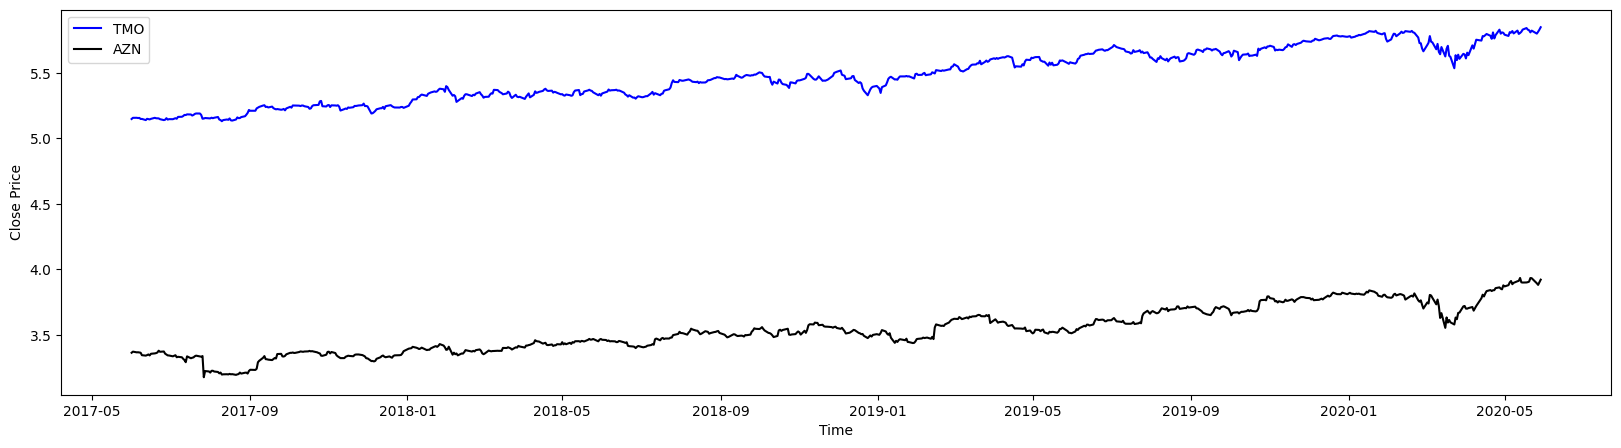

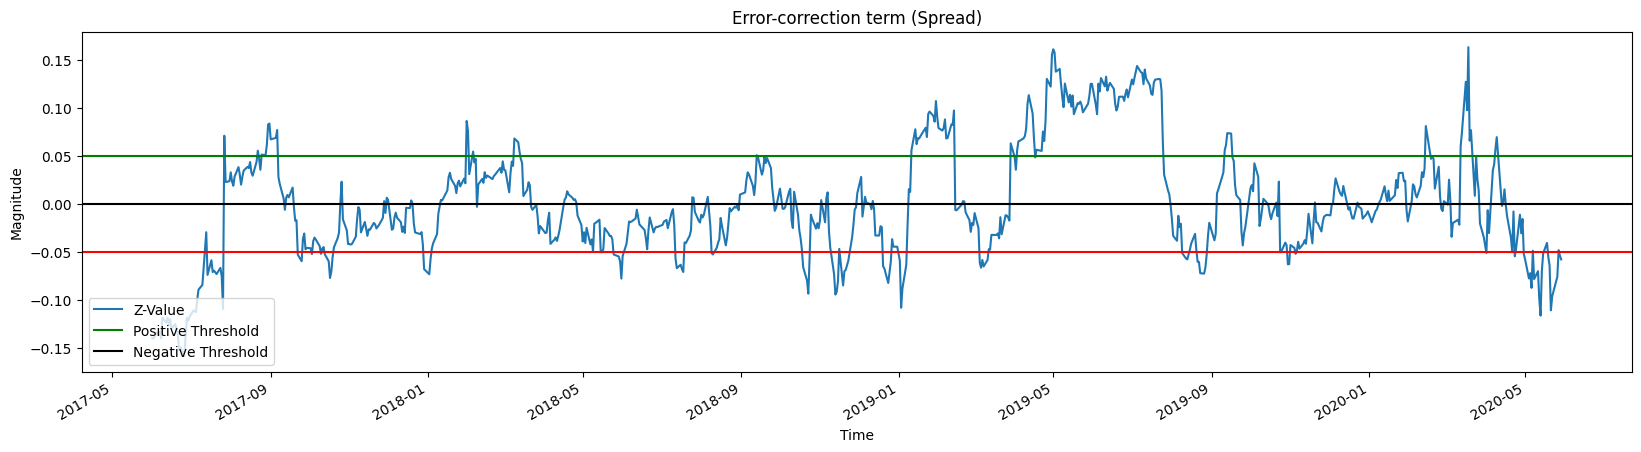

In [66]:
S1 = 'TMO'
S2 = 'AZN'
strat, gamma = strategy(S1,S2,1,1)

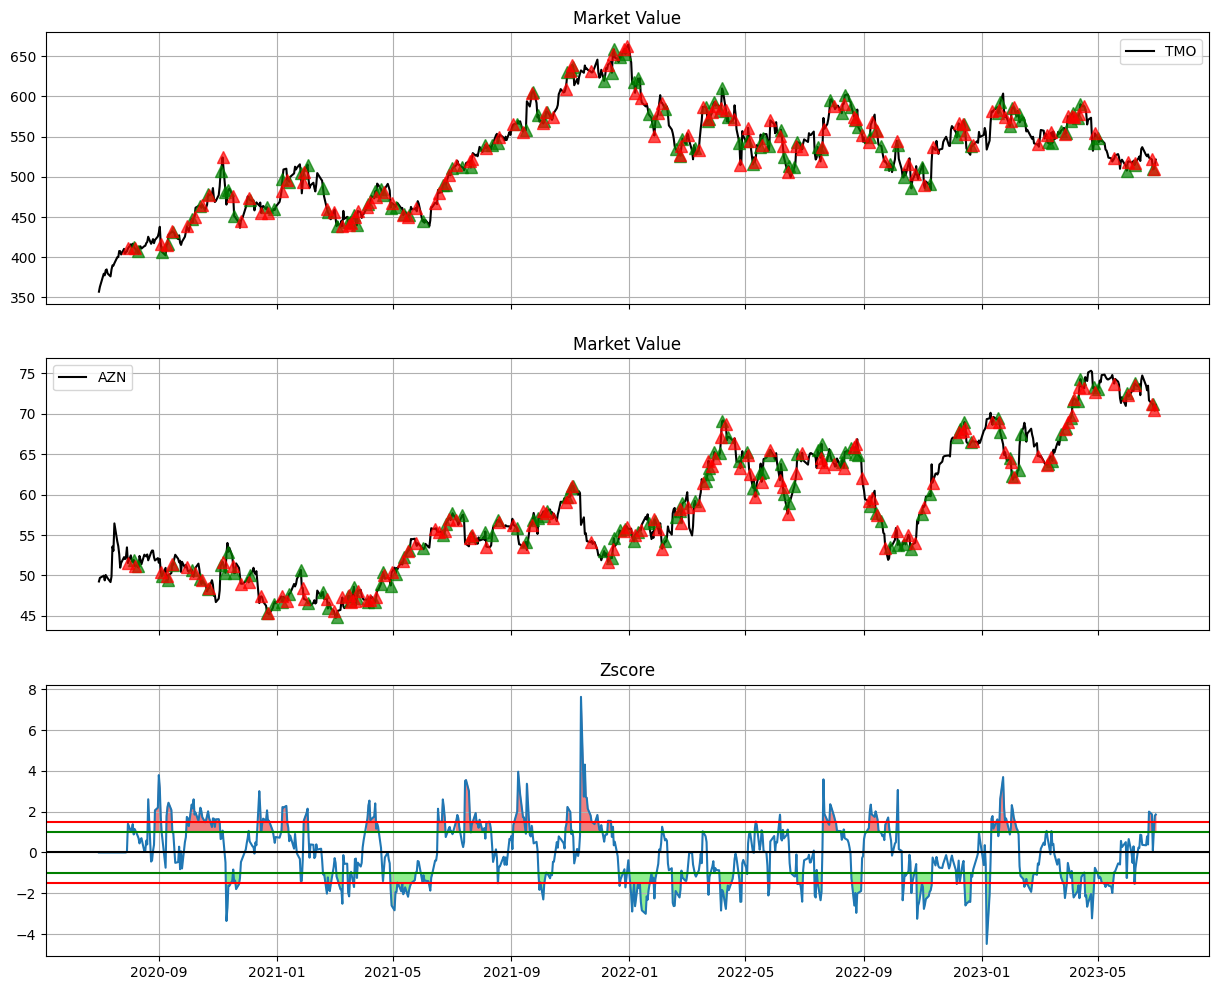

In [67]:
visualize_strategy(strat)

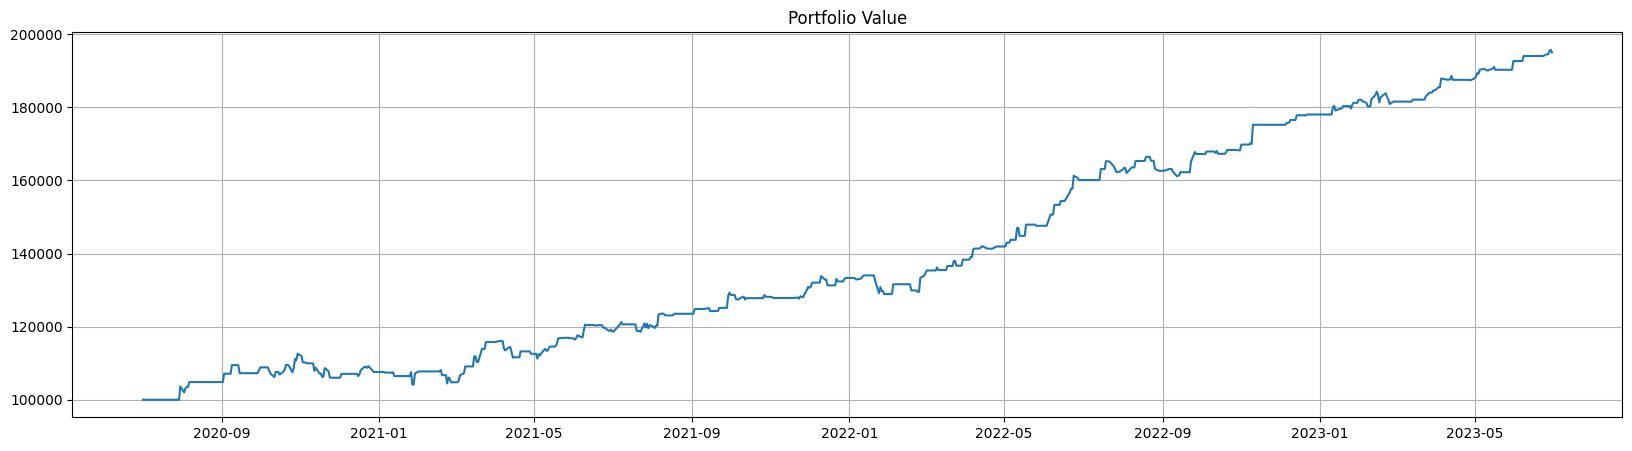

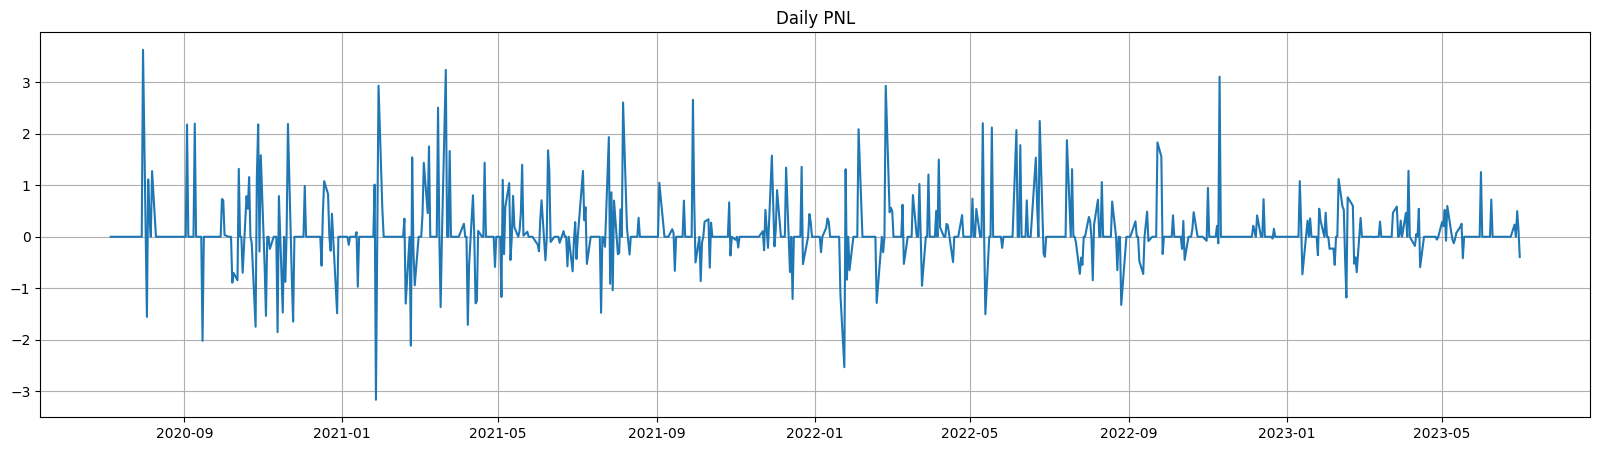

Profit : 94.94550422416305 %
CAGR : 24.95848131626268 %
Sharpe Ratio: 2.0290022972603134
Maximum Drawdown: 7.4991227039676955
Trades taken: 249


In [68]:
metrics(strat)